In [29]:
import matplotlib
matplotlib.__version__

'3.7.0'

In [30]:

import seaborn as sns; sns.set_palette("Set1")
%matplotlib inline
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F

In [31]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("dataPreparation").getOrCreate()

medical = spark.read.csv("medical_data.csv", header=True, inferSchema=True)
patient = spark.read.csv("patient_data.csv", header=True, inferSchema=True)

medical = medical.withColumn("chol", medical.chol.cast('integer'))
medical = medical.withColumn("exang", medical.exang.cast('integer'))
patient = patient.withColumn("sex", patient.sex.cast("integer"))

## Integratnio (merge data)

In [32]:
heart = patient.join(medical, on="id", how="inner")

heart = heart.drop("id")

In [33]:
print("Patient data shape (Rows, Columns):", (patient.count(), len(patient.columns)))
print("Medical data shape (Rows, Columns):", (medical.count(), len(medical.columns)))

print("Merged data shape (Rows, Columns):", (heart.count(), len(heart.columns)))

spark.createDataFrame(heart.describe().toPandas().transpose().reset_index()).show(truncate=False)

Patient data shape (Rows, Columns): (1025, 3)
Medical data shape (Rows, Columns): (1025, 13)
Merged data shape (Rows, Columns): (1025, 14)
+--------+-----+-------------------+-------------------+---+---+
|index   |0    |1                  |2                  |3  |4  |
+--------+-----+-------------------+-------------------+---+---+
|summary |count|mean               |stddev             |min|max|
|age     |1025 |54.43414634146342  |9.072290233244278  |29 |77 |
|sex     |987  |0.7001013171225937 |0.45844563856310544|0  |1  |
|cp      |1025 |0.9424390243902439 |1.029640743645865  |0  |3  |
|trestbps|1025 |131.61170731707318 |17.516718005376408 |94 |200|
|chol    |982  |246.01221995926682 |51.7080514274769   |126|564|
|fbs     |1025 |0.14926829268292682|0.35652668972715756|0  |1  |
|restecg |1025 |0.5297560975609756 |0.5278775668748918 |0  |2  |
|thalach |1025 |149.11414634146342 |23.00572374597721  |71 |202|
|exang   |965  |0.3378238341968912 |0.4732134233484412 |0  |1  |
|oldpeak |1025 |

23/10/10 23:40:09 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 926090 ms exceeds timeout 120000 ms
23/10/10 23:40:09 WARN SparkContext: Killing executors is not supported by current scheduler.
23/10/10 23:40:12 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

## Handle duplicates

In [6]:
medical_unique_rows = medical.drop("id").distinct().count()
print("Medical data unique rows:", medical_unique_rows)

heart = heart.dropDuplicates()
combined_unique_rows = heart.count()
print("Combined dataset unique rows:", combined_unique_rows)

Medical data unique rows: 398
Combined dataset unique rows: 432


In [7]:
from ydata_profiling import ProfileReport
heart_report = ProfileReport(heart.toPandas())
heart_report.to_file("heart_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Removing bad classes

In [9]:
thal_counts = heart.groupBy("thal").count().orderBy("count", ascending=False)
print("Counts for 'thal' column:")
thal_counts.show()

print()

ca_counts = heart.groupBy("ca").count().orderBy("count", ascending=False)
print("Counts for 'ca' column:")
ca_counts.show()

print()

rest_ecg_counts = heart.groupBy("restecg").count().orderBy("count", ascending=False)
print("Counts for 'restecg' column:")
rest_ecg_counts.show()


Counts for 'thal' column:
+----+-----+
|thal|count|
+----+-----+
|   2|  241|
|   3|  160|
|   1|   28|
|   0|    3|
+----+-----+


Counts for 'ca' column:
+---+-----+
| ca|count|
+---+-----+
|  0|  258|
|  1|   86|
|  2|   55|
|  3|   28|
|  4|    5|
+---+-----+


Counts for 'restecg' column:
+-------+-----+
|restecg|count|
+-------+-----+
|      1|  220|
|      0|  207|
|      2|    5|
+-------+-----+



In [10]:
heart = heart.filter(~((col("thal") == 0) | (col("ca") == 4) | (col("restecg") == 2)))

In [11]:
thal_counts = heart.groupBy("thal").count().orderBy("count", ascending=False)
print("Counts for 'thal' column:")
thal_counts.show()

print()

ca_counts = heart.groupBy("ca").count().orderBy("count", ascending=False)
print("Counts for 'ca' column:")
ca_counts.show()

print()

rest_ecg_counts = heart.groupBy("restecg").count().orderBy("count", ascending=False)
print("Counts for 'restecg' column:")
rest_ecg_counts.show()


Counts for 'thal' column:
+----+-----+
|thal|count|
+----+-----+
|   2|  237|
|   3|  156|
|   1|   26|
+----+-----+


Counts for 'ca' column:
+---+-----+
| ca|count|
+---+-----+
|  0|  253|
|  1|   85|
|  2|   55|
|  3|   26|
+---+-----+


Counts for 'restecg' column:
+-------+-----+
|restecg|count|
+-------+-----+
|      1|  216|
|      0|  203|
+-------+-----+



## Create new variables

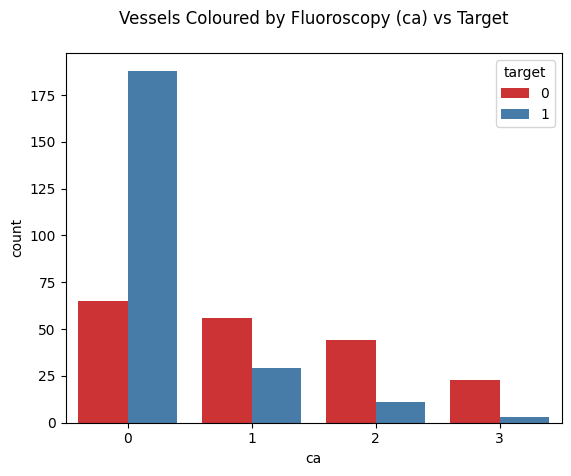

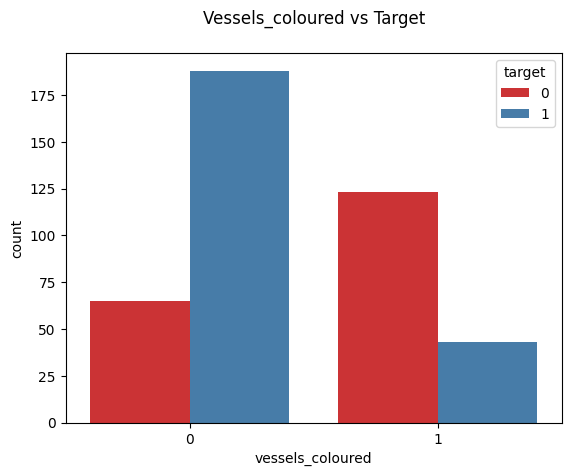

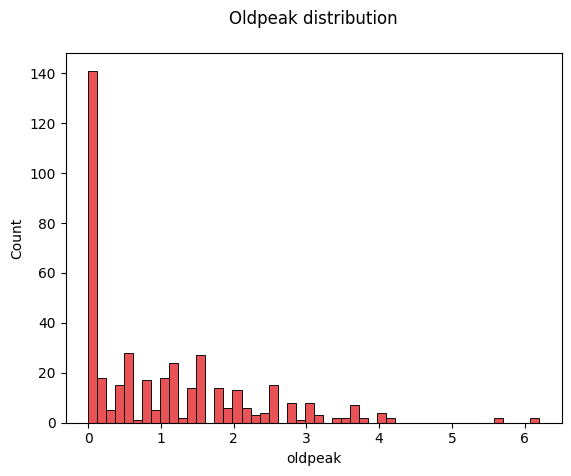

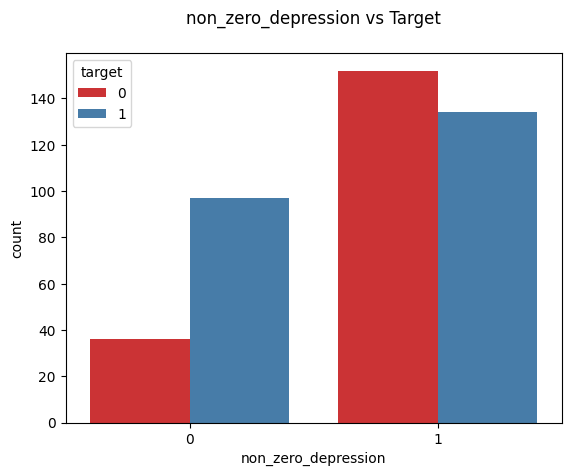

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-------+-------------------+----------------+-------------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|retired|high_blood_pressure|vessels_coloured|non_zero_depression|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+-------+-------------------+----------------+-------------------+
| 57|  0|  1|     130| 236|  0|      0|    174|    0|    0.0|    1|  1|   2|     0|      0|                  1|               1|                  0|
| 49|  1|  2|     120| 188|  0|      1|    139|    0|    2.0|    1|  3|   3|     0|      0|                  0|               1|                  1|
| 59|  1|  0|     170| 326|  0|      0|    140|    1|    3.4|    0|  0|   3|     0|      0|                  1|               0|                  1|
| 40|  1|  3|     140| 199|  0|      1|    178|    1|    1.4|    2|  0|   3|     1|      0|               

In [12]:
from pyspark.sql.functions import when

heart = heart.withColumn("retired", when(col("age") < 65, 0).otherwise(1))
heart = heart.withColumn("high_blood_pressure", when(col("trestbps") <= 120, 0).otherwise(1))
heart = heart.withColumn("vessels_coloured", when(col("ca") == 0, 0).otherwise(1))
heart = heart.withColumn("non_zero_depression", when(col("oldpeak") == 0, 0).otherwise(1))


sns.countplot(data=heart.toPandas(), x='ca', hue='target')
plt.title('Vessels Coloured by Fluoroscopy (ca) vs Target\n')
plt.show()


sns.countplot(data=heart.toPandas(), x='vessels_coloured', hue='target')
plt.title('Vessels_coloured vs Target\n')
plt.show()


sns.histplot(data=heart.toPandas(), x='oldpeak', bins=50)
plt.title('Oldpeak distribution\n')
plt.show()


sns.countplot(data=heart.toPandas(), x='non_zero_depression', hue='target')
plt.title('non_zero_depression vs Target\n')
plt.show()


heart.show(5)
print("Dataset shape (Rows, Columns):", (heart.count(), len(heart.columns)))


## Split into train/test

In [13]:
train_ratio = 0.8 

heart = heart.select("*").orderBy(F.rand()) #Randomize row order

train, test = heart.randomSplit([train_ratio, 1.0 - train_ratio], seed=722)

print("Train data observations:", train.count())
print("Test data observations:", test.count())

Train data observations: 336
Test data observations: 83


In [14]:
train_profile = ProfileReport(train.toPandas(), title="Train Data")
train_profile.to_file("train_data.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Handle outliers

In [15]:
print("Train set shape with outliers (Rows, Columns):", (train.count(), len(train.columns)))
train = train.filter(~(col("oldpeak") > 5))
train = train.filter("chol < 380 OR ISNULL(chol)")
print("Train set shape without outliers (Rows, Columns):", (train.count(), len(train.columns)))

Train set shape with outliers (Rows, Columns): (336, 18)
Train set shape without outliers (Rows, Columns): (329, 18)


In [16]:
print("Missing values in the train dataset:")
for col_name in train.columns:
    missing_count = train.filter((col(col_name) == "NA") | (col(col_name).isNull())).count()
    print(f"{col_name}: {missing_count}")

Missing values in the train dataset:
age: 0
sex: 29
cp: 0
trestbps: 0
chol: 35
fbs: 0
restecg: 0
thalach: 0
exang: 44
oldpeak: 0
slope: 0
ca: 0
thal: 0
target: 0
retired: 0
high_blood_pressure: 0
vessels_coloured: 0
non_zero_depression: 0


23/10/10 16:34:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


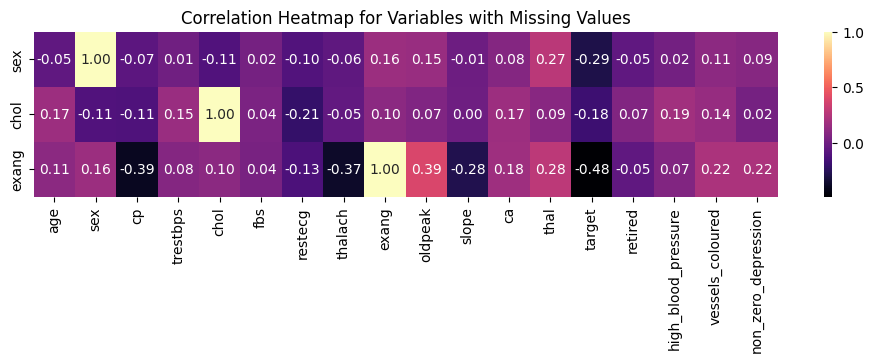

In [17]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

no_na_vals = train.na.drop()

selected_cols = ["sex", "chol", "exang"]

assembler = VectorAssembler(inputCols=no_na_vals.columns, outputCol="features")
no_na_vals = assembler.transform(no_na_vals)

corr_matrix = Correlation.corr(no_na_vals, "features").head()


corr_df = spark.createDataFrame(corr_matrix[0].toArray(),
                                schema = no_na_vals.columns[:-1])

corr_df = corr_df.select(selected_cols)
corr_df = corr_df.toPandas()

plt.figure(figsize=(12, 5))
sns.heatmap(corr_df.transpose(), annot=True, cmap="magma", fmt='.2f', xticklabels=no_na_vals.columns[:-1])
plt.title("Correlation Heatmap for Variables with Missing Values")
plt.subplots_adjust(bottom=0.55)
plt.show()

In [18]:
chol_median = train.approxQuantile("chol", [0.5], 0.001)[0]
train = train.fillna({"chol": chol_median})
test = test.fillna({"chol": chol_median})


sex_mode = train.groupBy("sex").count().orderBy(col("count").desc()).first()["sex"]
train = train.fillna({"chol": chol_median, "sex": sex_mode})
test = test.fillna({"chol": chol_median, "sex": sex_mode})

print("\nMissing values after filling:")
for col_name in train.columns:
    missing_count = train.filter((col(col_name) == "NA") | (col(col_name).isNull())).count()
    print(f"{col_name}: {missing_count}")


Missing values after filling:
age: 0
sex: 0
cp: 0
trestbps: 0
chol: 0
fbs: 0
restecg: 0
thalach: 0
exang: 44
oldpeak: 0
slope: 0
ca: 0
thal: 0
target: 0
retired: 0
high_blood_pressure: 0
vessels_coloured: 0
non_zero_depression: 0


In [19]:
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler,StringIndexer

no_na_vals = train.na.drop()

feature_columns = [colname for colname in train.columns if colname != "exang"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
indexer = StringIndexer(inputCol="exang", outputCol="label")
evaluator = BinaryClassificationEvaluator()

models = [RandomForestClassifier(featuresCol='features', labelCol="label"), 
          LinearSVC(featuresCol='features', labelCol="label"), 
          LogisticRegression(featuresCol='features', labelCol="label")]

model_results = []

folds = 5

for model in models: #Perform CV for each model
    pipeline = Pipeline(stages=[assembler, indexer, model])
    grid = ParamGridBuilder().build()

    crossval = CrossValidator(estimator=pipeline,
                              evaluator=evaluator,
                              estimatorParamMaps=grid,
                              numFolds=folds,
                              seed=722,
                              parallelism=20)
    
    cvModel = crossval.fit(no_na_vals)
    accuracy = sum(cvModel.avgMetrics) / len(cvModel.avgMetrics)
    model_results.append((model, cvModel, accuracy))

# Print model results
for model, cvModel, accuracy in model_results:
    print(f"{model.__class__.__name__} accuracy: {accuracy:.3f}")


RandomForestClassifier accuracy: 0.854
LinearSVC accuracy: 0.821
LogisticRegression accuracy: 0.819


In [20]:
rf = model_results[0][1].bestModel

no_na_vals = train.na.drop()
na_rows = train.filter("exang is NULL")
predicted = rf.transform(na_rows).select(na_rows.columns + ["prediction"])
predicted = predicted.withColumn("exang", predicted.prediction).select(na_rows.columns)
train = no_na_vals.unionByName(predicted)

test_no_na_vals = test.na.drop()
test_na_rows = test.filter("exang is NULL")
predicted = rf.transform(test_na_rows).select(test_na_rows.columns + ["prediction"])
predicted = predicted.withColumn("exang", predicted.prediction).select(test_na_rows.columns)
test = test_no_na_vals.unionByName(predicted)

In [21]:
print("\nMissing values after filling: (train - test)")
for col_name in train.columns:
    missing_count = train.filter((col(col_name) == "NA") | (col(col_name).isNull())).count()
    test_missing_count = test.filter((col(col_name) == "NA") | (col(col_name).isNull())).count()
    print(f"{col_name}: ({missing_count} - {test_missing_count})")


Missing values after filling: (train - test)
age: (0 - 0)
sex: (0 - 0)
cp: (0 - 0)
trestbps: (0 - 0)
chol: (0 - 0)
fbs: (0 - 0)
restecg: (0 - 0)
thalach: (0 - 0)
exang: (0 - 0)
oldpeak: (0 - 0)
slope: (0 - 0)
ca: (0 - 0)
thal: (0 - 0)
target: (0 - 0)
retired: (0 - 0)
high_blood_pressure: (0 - 0)
vessels_coloured: (0 - 0)
non_zero_depression: (0 - 0)


In [22]:
from pyspark.sql.functions import lit
from pprint import pprint

train = train.withColumn("partition", lit("train"))
test = test.withColumn("partition", lit("test"))

print("Train dataset shape (Rows, Columns):", (train.count(), len(train.columns)))
print("Test dataset shape (Rows, Columns):", (test.count(), len(test.columns)))

#Combine train and test
heart = train.unionByName(test)

print("Dataset shape (Rows, Columns):", (heart.count(), len(heart.columns)))

print("Current column names:")
pprint(heart.columns)

print()

#Update colnames to be more descriptive
new_colnames = ['age', 
                 'sex', 
                 'chest_pain_type', 
                 'resting_blood_pressure', 
                 'cholesterol', 
                 'fasting_blood_sugar', 
                 'rest_ecg_type', 
                 'max_heart_rate_achieved',
                 'exercise_induced_angina', 
                 'st_depression', 
                 'st_slope_type', 
                 'num_major_vessels', 
                 'thalassemia_type', 
                 'target'] + list(heart.columns[14:])

for i in range(len(new_colnames)):
    heart = heart.withColumnRenamed(heart.columns[i], new_colnames[i])

print("New column names:")
pprint(heart.columns)


Train dataset shape (Rows, Columns): (329, 19)
Test dataset shape (Rows, Columns): (83, 19)
Dataset shape (Rows, Columns): (412, 19)
Current column names:
['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target',
 'retired',
 'high_blood_pressure',
 'vessels_coloured',
 'non_zero_depression',
 'partition']

New column names:
['age',
 'sex',
 'chest_pain_type',
 'resting_blood_pressure',
 'cholesterol',
 'fasting_blood_sugar',
 'rest_ecg_type',
 'max_heart_rate_achieved',
 'exercise_induced_angina',
 'st_depression',
 'st_slope_type',
 'num_major_vessels',
 'thalassemia_type',
 'target',
 'retired',
 'high_blood_pressure',
 'vessels_coloured',
 'non_zero_depression',
 'partition']


In [23]:
from pyspark.sql.functions import when

# Replace non-flag variables with descriptive levels
# chest_pain_type
heart = heart.withColumn("chest_pain_type", when(heart["chest_pain_type"] == 0, "asymptomatic")
                            .when(heart["chest_pain_type"] == 1, "atypical_angina")
                            .when(heart["chest_pain_type"] == 2, "non-anginal_pain")
                            .when(heart["chest_pain_type"] == 3, "typical_angina"))

# st_slope_type
heart = heart.withColumn("st_slope_type", when(heart["st_slope_type"] == 0, "downsloping")
                            .when(heart["st_slope_type"] == 1, "flat")
                            .when(heart["st_slope_type"] == 2, "upsloping"))

# thalassemia_type
heart = heart.withColumn("thalassemia_type", when(heart["thalassemia_type"] == 1, "fixed_defect")
                            .when(heart["thalassemia_type"] == 2, "normal")
                            .when(heart["thalassemia_type"] == 3, "reversible_defect"))

heart.show(5)


+---+---+---------------+----------------------+-----------+-------------------+-------------+-----------------------+-----------------------+-------------+-------------+-----------------+-----------------+------+-------+-------------------+----------------+-------------------+---------+
|age|sex|chest_pain_type|resting_blood_pressure|cholesterol|fasting_blood_sugar|rest_ecg_type|max_heart_rate_achieved|exercise_induced_angina|st_depression|st_slope_type|num_major_vessels| thalassemia_type|target|retired|high_blood_pressure|vessels_coloured|non_zero_depression|partition|
+---+---+---------------+----------------------+-----------+-------------------+-------------+-----------------------+-----------------------+-------------+-------------+-----------------+-----------------+------+-------+-------------------+----------------+-------------------+---------+
| 29|  1|atypical_angina|                   130|        204|                  0|            0|                    202|               

In [24]:
from pyspark.sql import functions as F

categorical_cols = ["chest_pain_type", "st_slope_type", "thalassemia_type"]

for column in categorical_cols:
    categories = heart.select(column).distinct().rdd.flatMap(lambda x: x).collect()
    for category in categories:
        heart = heart.withColumn(column + "_" + category, F.when(F.col(column) == category, 1).otherwise(0))

heart = heart.drop(*categorical_cols)

In [25]:

heart.show(5)

+---+---+----------------------+-----------+-------------------+-------------+-----------------------+-----------------------+-------------+-----------------+------+-------+-------------------+----------------+-------------------+---------+----------------------------+--------------------------------+-------------------------------+------------------------------+------------------+-------------------------+-----------------------+----------------------------------+-----------------------+-----------------------------+
|age|sex|resting_blood_pressure|cholesterol|fasting_blood_sugar|rest_ecg_type|max_heart_rate_achieved|exercise_induced_angina|st_depression|num_major_vessels|target|retired|high_blood_pressure|vessels_coloured|non_zero_depression|partition|chest_pain_type_asymptomatic|chest_pain_type_non-anginal_pain|chest_pain_type_atypical_angina|chest_pain_type_typical_angina|st_slope_type_flat|st_slope_type_downsloping|st_slope_type_upsloping|thalassemia_type_reversible_defect|thalass

In [26]:

float_cols = ["st_depression"]

int_cols = ['age',
            'sex',
            'resting_blood_pressure',
            'cholesterol',
            'fasting_blood_sugar',
            'rest_ecg_type',
            'max_heart_rate_achieved',
            'exercise_induced_angina',
            'num_major_vessels',
            'target',
            'retired',
            'high_blood_pressure',
            'vessels_coloured',
            'non_zero_depression',
            'chest_pain_type_asymptomatic',
            'chest_pain_type_non-anginal_pain',
            'chest_pain_type_atypical_angina',
            'chest_pain_type_typical_angina',
            'st_slope_type_flat',
            'st_slope_type_downsloping',
            'st_slope_type_upsloping',
            'thalassemia_type_reversible_defect',
            'thalassemia_type_normal',
            'thalassemia_type_fixed_defect']

string_cols = ['partition']

for column in [col for col in float_cols]:
    heart = heart.withColumn(column, heart[column].cast('float'))

for column in [col for col in int_cols]:
    heart = heart.withColumn(column, heart[column].cast('int'))

for column in [col for col in string_cols]:
    heart = heart.withColumn(column, heart[column].cast('string'))

print("Dataset shape with outliers (Rows, Columns):", (heart.count(), len(heart.columns)))
print(heart.printSchema())

heart.toPandas().to_csv("cleaned_heart.csv", index=False, header=heart.columns)

Dataset shape with outliers (Rows, Columns): (412, 26)
root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = false)
 |-- resting_blood_pressure: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- fasting_blood_sugar: integer (nullable = true)
 |-- rest_ecg_type: integer (nullable = true)
 |-- max_heart_rate_achieved: integer (nullable = true)
 |-- exercise_induced_angina: integer (nullable = true)
 |-- st_depression: float (nullable = true)
 |-- num_major_vessels: integer (nullable = true)
 |-- target: integer (nullable = true)
 |-- retired: integer (nullable = false)
 |-- high_blood_pressure: integer (nullable = false)
 |-- vessels_coloured: integer (nullable = false)
 |-- non_zero_depression: integer (nullable = false)
 |-- partition: string (nullable = false)
 |-- chest_pain_type_asymptomatic: integer (nullable = false)
 |-- chest_pain_type_non-anginal_pain: integer (nullable = false)
 |-- chest_pain_type_atypical_angina: integer (nullable = 

In [27]:
heart.describe()
heart.show(5)

+---+---+----------------------+-----------+-------------------+-------------+-----------------------+-----------------------+-------------+-----------------+------+-------+-------------------+----------------+-------------------+---------+----------------------------+--------------------------------+-------------------------------+------------------------------+------------------+-------------------------+-----------------------+----------------------------------+-----------------------+-----------------------------+
|age|sex|resting_blood_pressure|cholesterol|fasting_blood_sugar|rest_ecg_type|max_heart_rate_achieved|exercise_induced_angina|st_depression|num_major_vessels|target|retired|high_blood_pressure|vessels_coloured|non_zero_depression|partition|chest_pain_type_asymptomatic|chest_pain_type_non-anginal_pain|chest_pain_type_atypical_angina|chest_pain_type_typical_angina|st_slope_type_flat|st_slope_type_downsloping|st_slope_type_upsloping|thalassemia_type_reversible_defect|thalass